# Biliotecas

In [3]:
# Instala os pacotes necessários:
# - gymnasium[toy-text]: inclui ambientes simples como FrozenLake, Taxi, etc.
# - imageio[ffmpeg]: permite salvar vídeos e GIFs (formato .mp4 ou .gif)
# %pip install gymnasium[toy-text] imageio[ffmpeg]

In [4]:
# Importa as bibliotecas principais
import gymnasium as gym               # Biblioteca de simulações de ambientes para RL
import imageio                        # Usada para salvar a sequência de frames como GIF
from IPython.display import Image     # Para exibir a imagem (GIF) diretamente no notebook
import numpy as np                    # Importa o pacote NumPy, amplamente utilizado para manipulação de arrays e operações numéricas vetoriais
from typing import Dict, Tuple, List  # Importa ferramentas de tipagem estática do Python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Implementação do SARSA

In [5]:

def sarsa(
    env,
    episodes: int,
    alpha: float,
    gamma: float,
    epsilon: float
) -> Tuple[np.ndarray, List[int], List[float], Dict[int, np.ndarray]]:

    # Linha 0 : Inicializa variáveis para armazenar o comprimento dos episódios, retornos e política
    n_states = env.observation_space.n  # Número de estados no ambiente
    n_actions = env.action_space.n      # Número de ações possíveis no ambiente
    q_table = np.zeros((n_states, n_actions))  # Inicializa a Q-table com zeros
    # Pio derivada de Qo: inicialmente uniforme
    politica: Dict[int, np.ndarray] = {
        s: np.ones(n_actions) / n_actions for s in range(n_states)
    }

    episodio_len    : List[int]   = []  # armazena número de passos por episódio
    episodio_return : List[float] = []  # armazena retorno total por episódio

    # (Linha 1) Para cada episódio
    for ep in range(episodes):
        state, _ = env.reset()                            # reinicia o ambiente
        # (Linha 2) Gera A₀ em S₀ seguindo π₀(S₀)
        action = np.random.choice(n_actions, p=politica[state])

        total_return = 0.0
        t = 0
        done = False

        # (Linha 3) Enquanto Sₜ não for estado terminal (no CliffWalking-v0 usamos `done`)
        while not done:
            # (Linha 4) Coleta experiência: Rₜ₊₁, Sₜ₊₁
            next_state, reward, done, truncated, info = env.step(action)
            total_return += reward

            # (Linha 4) Gera Aₜ₊₁ em Sₜ₊₁ seguindo πₜ
            next_action = np.random.choice(n_actions, p=politica[next_state])

            # (Linhas 5–6) Atualiza Q(Sₜ, Aₜ):
            # Q ← Q + α [ Rₜ₊₁ + γ Q(Sₜ₊₁,Aₜ₊₁) − Q(Sₜ,Aₜ) ]
            td_target = reward + gamma * q_table[next_state, next_action]
            td_error  = td_target - q_table[state, action]
            q_table[state, action] += alpha * td_error

            # (Linhas 7–9) Atualiza política ε-greedy em Sₜ:
            best_action = np.argmax(q_table[state])
            for a in range(n_actions):
                if a == best_action:
                    # (Linha 8) ação gulosa com prob. 1−ε + ε/|A|
                    politica[state][a] = 1 - epsilon + epsilon / n_actions
                else:
                    # (Linha 9) demais ações com prob. ε/|A|
                    politica[state][a] = epsilon / n_actions

            # (Linha 10) Avança para o próximo passo: Sₜ ← Sₜ₊₁, Aₜ ← Aₜ₊₁
            state, action = next_state, next_action
            t += 1

        # registra métricas do episódio
        episodio_len.append(t)
        episodio_return.append(total_return)

    return q_table, episodio_len, episodio_return, politica

# Visualização

In [6]:
def plotar_metricas(episodio_len: list[int], episodio_return: list[float], janela: int = 100) -> None:
    """
    Plota as métricas de comprimento e retorno dos episódios.
    :param episodio_len: Lista de comprimentos dos episódios.
    :param episodio_return: Lista de retornos dos episódios.
    :param janela: Tamanho da janela para suavização dos dados.
    """
    # Plot duração do episódio por episódio e a recompensa total por episodio.
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episodio_len, label='Comprimento do Episódio', color='blue')
    plt.xlabel('Episódio')
    plt.ylabel('Comprimento')
    plt.title('Comprimento do Episódio ao Longo do Tempo')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(episodio_return, label='Retorno do Episódio', color='green')
    plt.xlabel('Episódio')
    plt.ylabel('Retorno')
    plt.title('Retorno do Episódio ao Longo do Tempo')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    


In [7]:
def gerar_gif_epsilon_greedy_politica(
    politica: Dict[int, np.ndarray],
    env,
    path_gif: str,
    n_episodios: int = 5
) -> str:
    frames = []
    n_actions = len(next(iter(politica.values())))

    for ep in range(n_episodios):
        state, _ = env.reset()
        for _ in range(100):
            action = np.random.choice(n_actions, p=politica[state])
            state, reward, terminated, truncated, _ = env.step(action)
            frames.append(env.render())
            if terminated or truncated:
                break

    env.close()
    imageio.mimsave(path_gif, frames, format="GIF", fps=2)
    return path_gif

# Simulação

In [8]:
# Configura o ambiente
map_name = '8x8'
render_mode = 'rgb_array'  # retorna imagens do ambiente como arrays de pixels
is_slippery = False  # torna o ambiente determinístico ou estocástico
env = gym.make("CliffWalking-v0")

In [9]:
# Hiper-parâmetros principais
EPISODIOS = 5000  # @param {type:"integer"}
ALPHA     = 0.2      # @param {type:"number"}  # comprimento máximo da sequência (+1 p/ token deslocado)
GAMMA     = 0.99     # @param {type:"number"}
EPSILON   = 0.1     # @param {type:"number"}

# Sarsa
q_table, ep_len, ep_ret, politica_eps = sarsa(
    env,
    episodes=EPISODIOS,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON
)

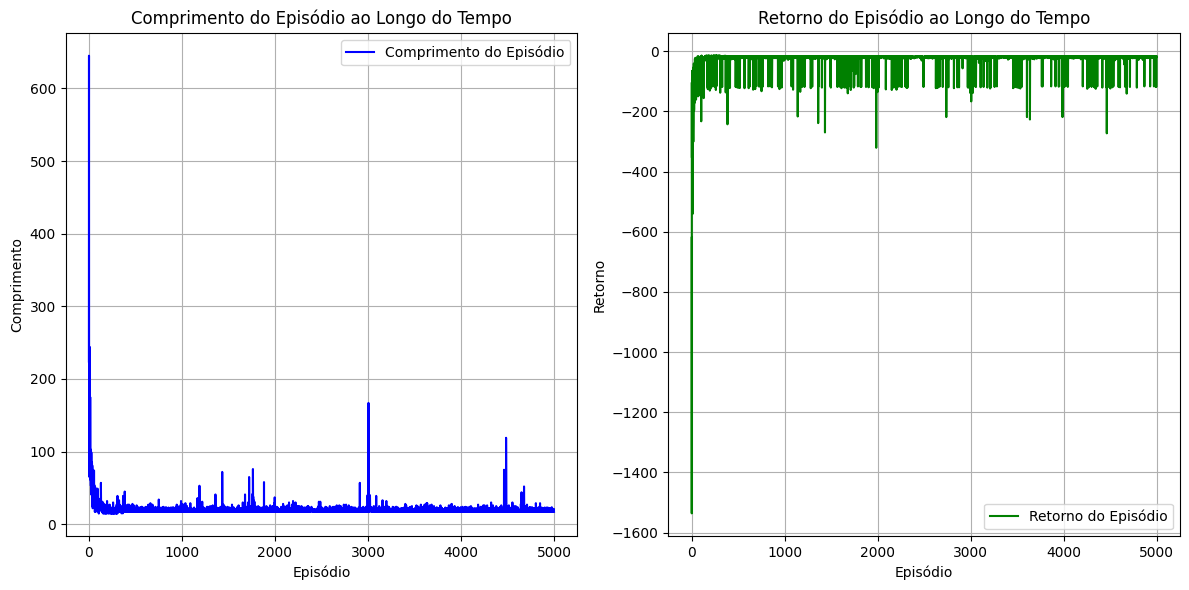

In [10]:
plotar_metricas(ep_len, ep_ret)

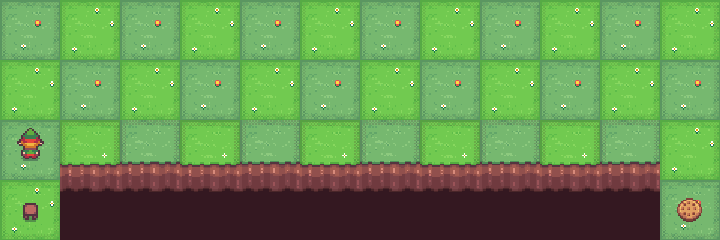

In [11]:
# Recria ambiente para renderizar
env_vis = gym.make("CliffWalking-v0", render_mode="rgb_array")

# Gera o GIF
gif_path = "politica_epsilon_gulosa.gif"
gerar_gif_epsilon_greedy_politica(politica_eps, env_vis, gif_path, n_episodios=5)


# Exibe o GIF diretamente no notebook
Image(filename=gif_path)

# Tarefa:

1. Implemente o algoritmo Sarsa
2. Considere os 4 hiperparametros (EPISODIOS, ALPHA, GAMMA, EPSILON). Varie um dos hiperparametros (ex.: EPISODIOS) e fixe os demais (ex.: ALPHA, GAMMA, EPSILON). Repita o procedimento para cada um dos hiperparametros. Reporte suas observações.
3. Plote a duração do episódio por episódio e também a recompensa total por episodio.

### Impacto do número de episódios

In [12]:
# Teste variando o número de episódios
episodios_variar = [100, 500, 1000, 2000, 5000]
resultados_episodios = {}

# Hiperparâmetros fixos
ALPHA_FIXO = 0.2
GAMMA_FIXO = 0.99
EPSILON_FIXO = 0.1

print("Testando impacto do número de episódios...")
for ep in episodios_variar:
    print(f"Executando com {ep} episódios...")
    env_teste = gym.make("CliffWalking-v0")
    
    q_table, ep_len, ep_ret, politica = sarsa(
        env_teste,
        episodes=ep,
        alpha=ALPHA_FIXO,
        gamma=GAMMA_FIXO,
        epsilon=EPSILON_FIXO
    )
    
    resultados_episodios[ep] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de episódios concluído!")

Testando impacto do número de episódios...
Executando com 100 episódios...
Executando com 500 episódios...
Executando com 1000 episódios...
Executando com 2000 episódios...
Executando com 5000 episódios...
Teste de episódios concluído!


Resultados para 100 episódios:


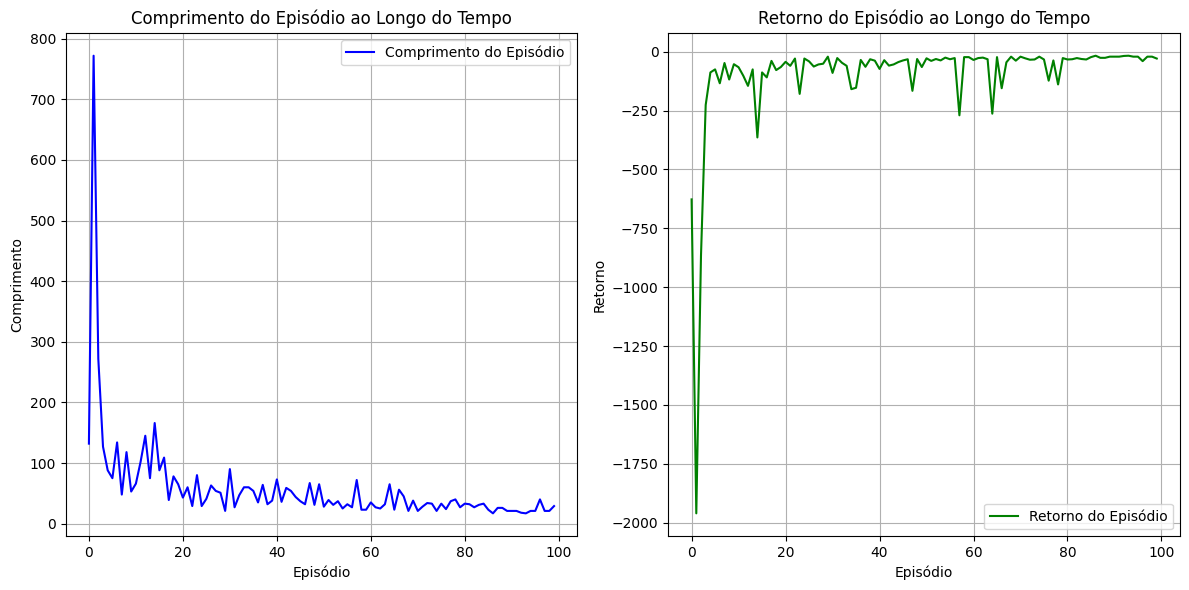

Resultados para 500 episódios:


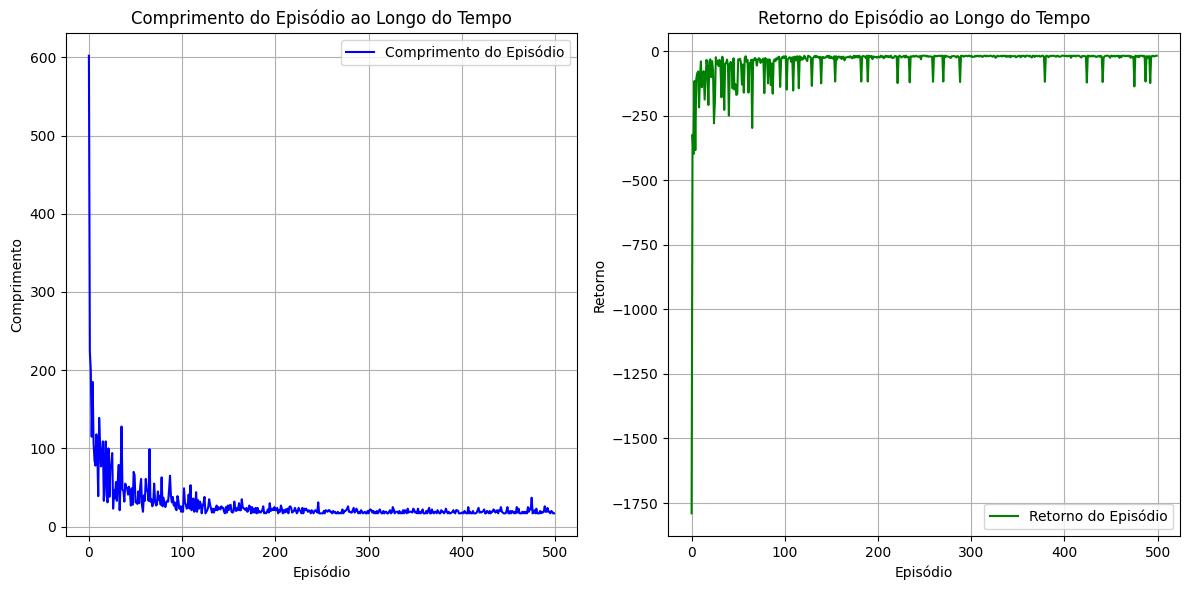

Resultados para 1000 episódios:


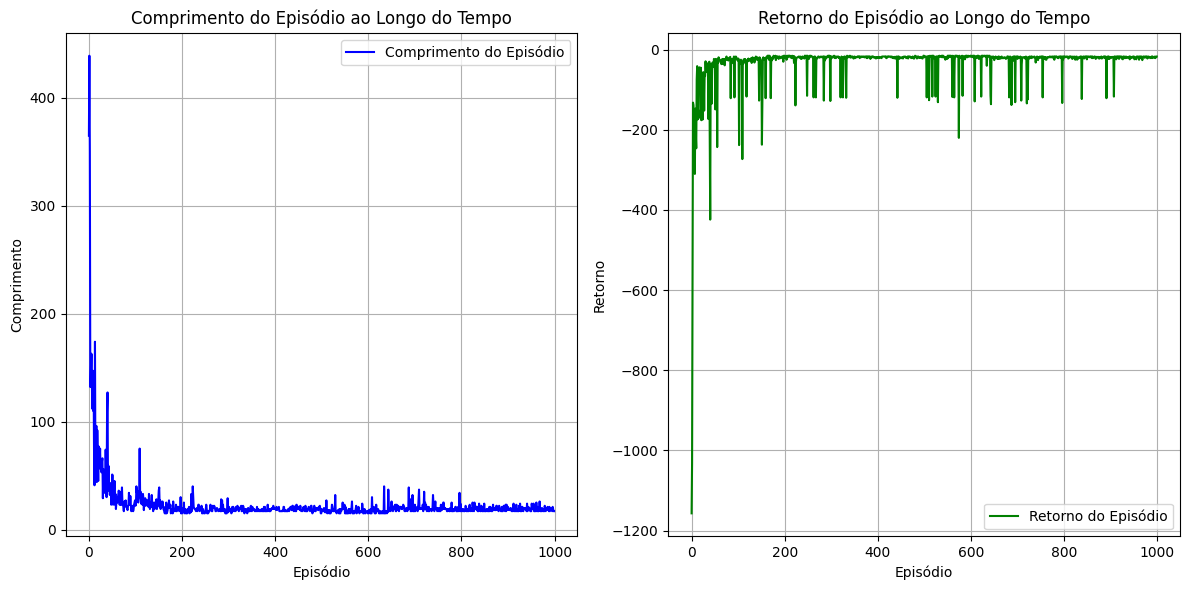

Resultados para 2000 episódios:


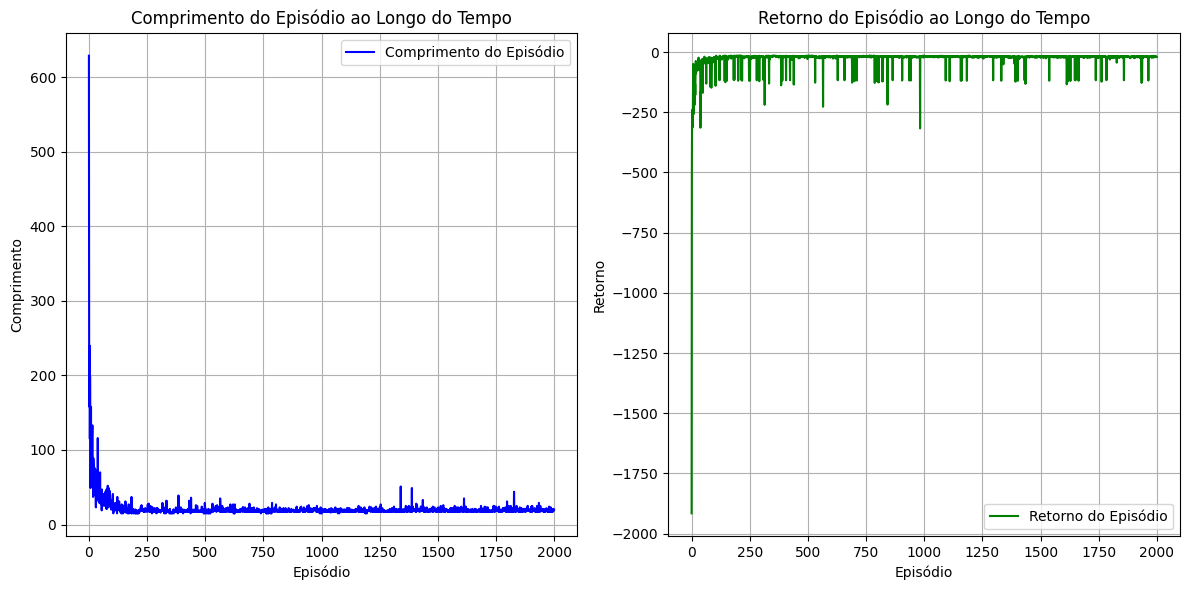

Resultados para 5000 episódios:


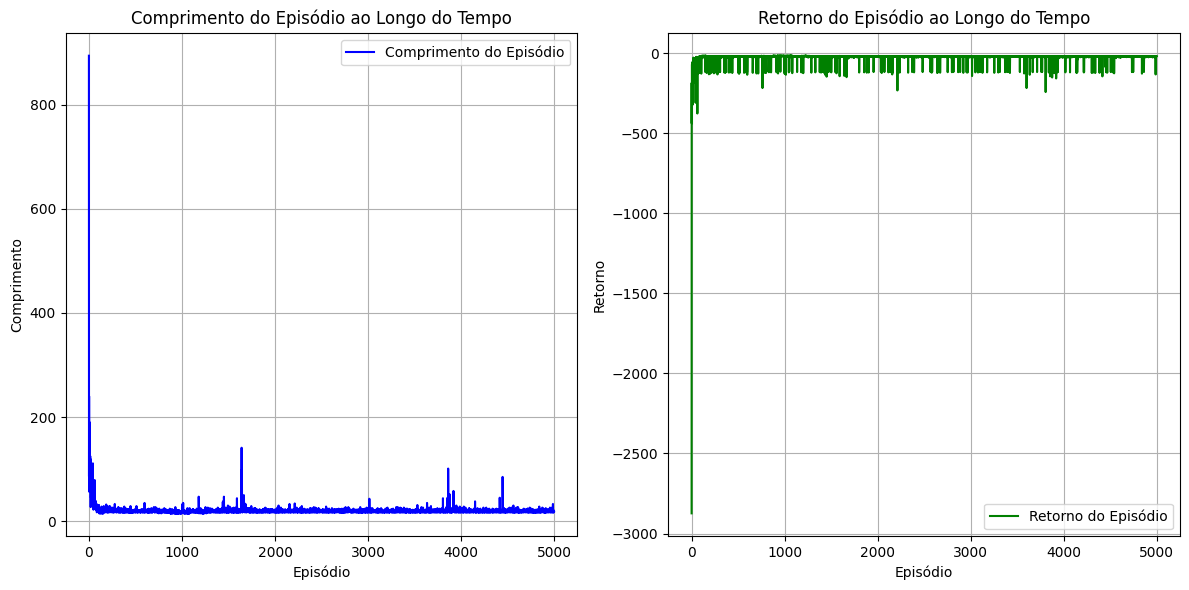

In [22]:
# Plotando o a duração dos episódios por epísodio e a recompensa total por episódio
for ep, resultados in resultados_episodios.items():
    print("=" * 40)
    print(f"Resultados para {ep} episódios:")
    print("=" * 40)
    plotar_metricas(resultados['ep_len'], resultados['ep_ret'])

### Impacto do alpha


In [23]:
# Teste variando o alpha (taxa de aprendizado)
alphas_variar = [0.01, 0.1, 0.2, 0.5, 0.9]
resultados_alpha = {}

# Hiperparâmetros fixos
EPISODIOS_FIXO = 1000
GAMMA_FIXO = 0.99
EPSILON_FIXO = 0.1

print("Testando impacto do alpha (taxa de aprendizado)...")
for alpha in alphas_variar:
    print(f"Executando com alpha = {alpha}...")
    env_teste = gym.make("CliffWalking-v0")
    
    q_table, ep_len, ep_ret, politica = sarsa(
        env_teste,
        episodes=EPISODIOS_FIXO,
        alpha=alpha,
        gamma=GAMMA_FIXO,
        epsilon=EPSILON_FIXO
    )
    
    resultados_alpha[alpha] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de alpha concluído!")

Testando impacto do alpha (taxa de aprendizado)...
Executando com alpha = 0.01...
Executando com alpha = 0.1...
Executando com alpha = 0.2...
Executando com alpha = 0.5...
Executando com alpha = 0.9...
Teste de alpha concluído!



Resultados para 100 episódios:


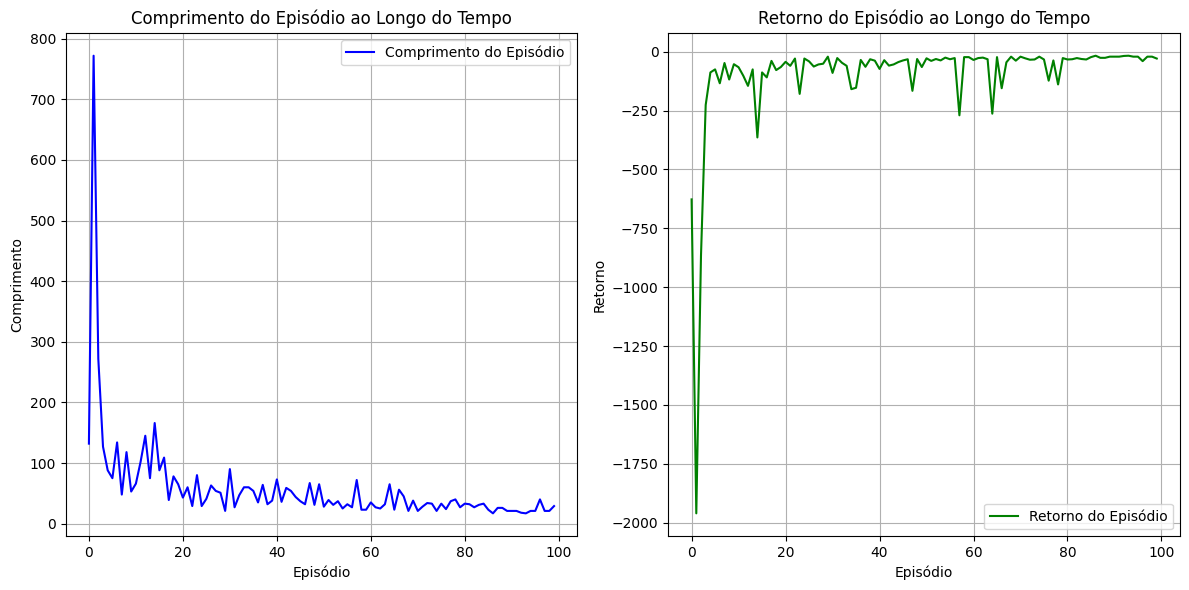


Resultados para 500 episódios:


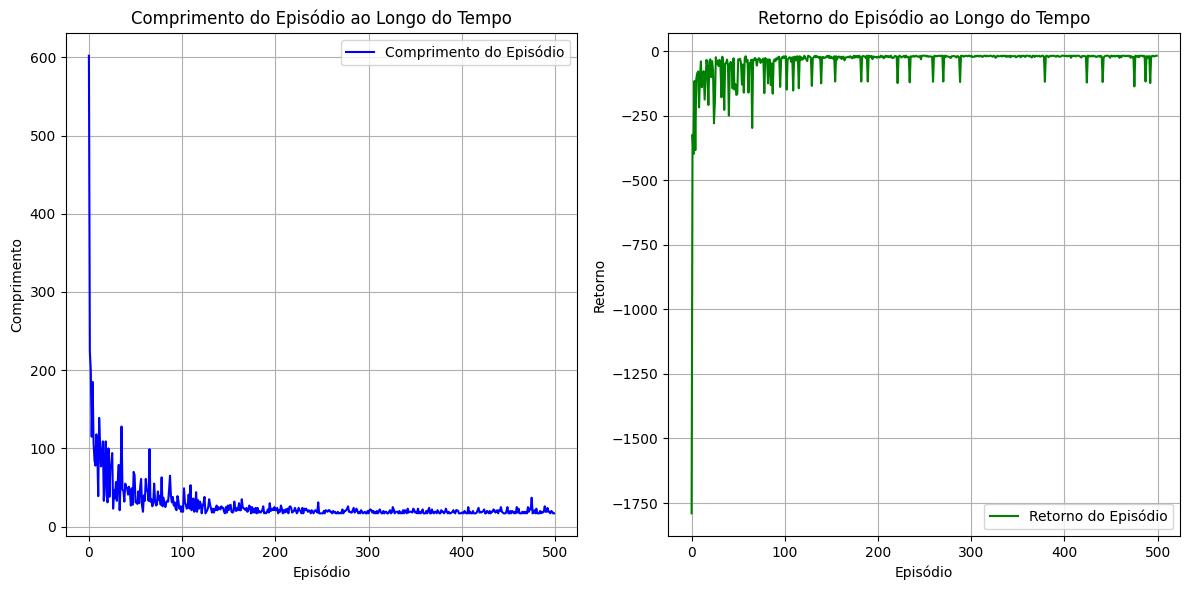


Resultados para 1000 episódios:


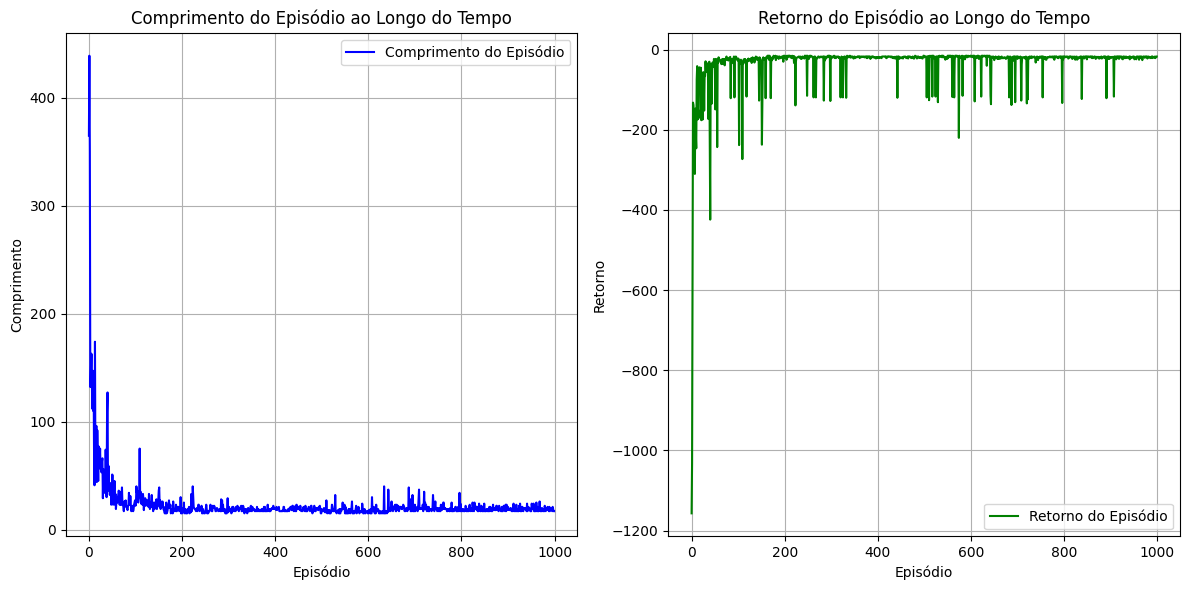


Resultados para 2000 episódios:


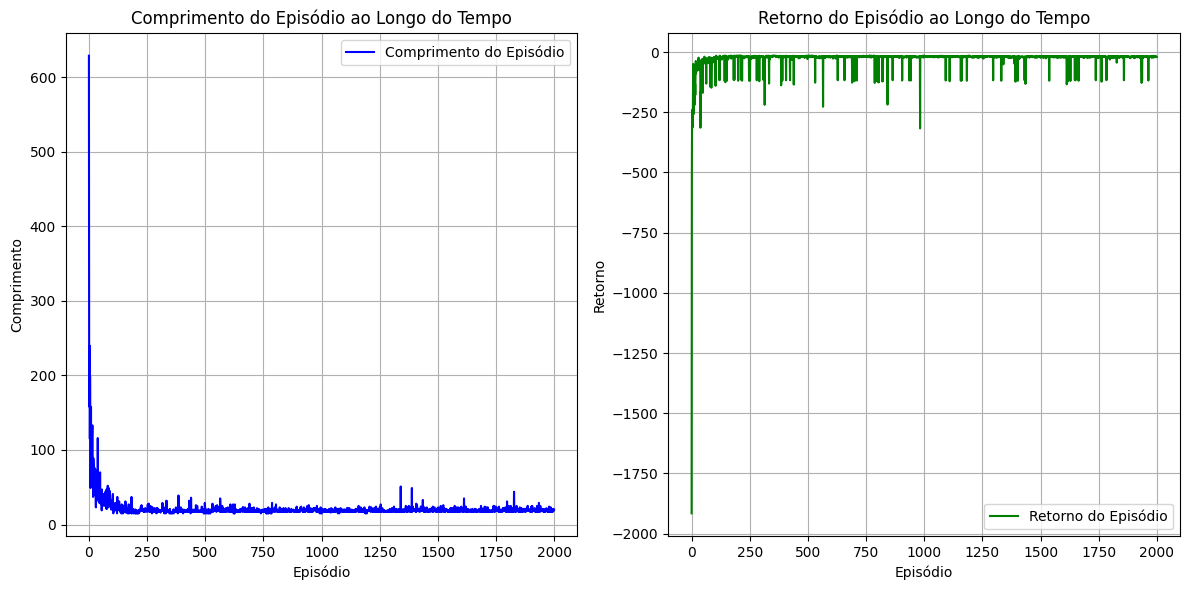


Resultados para 5000 episódios:


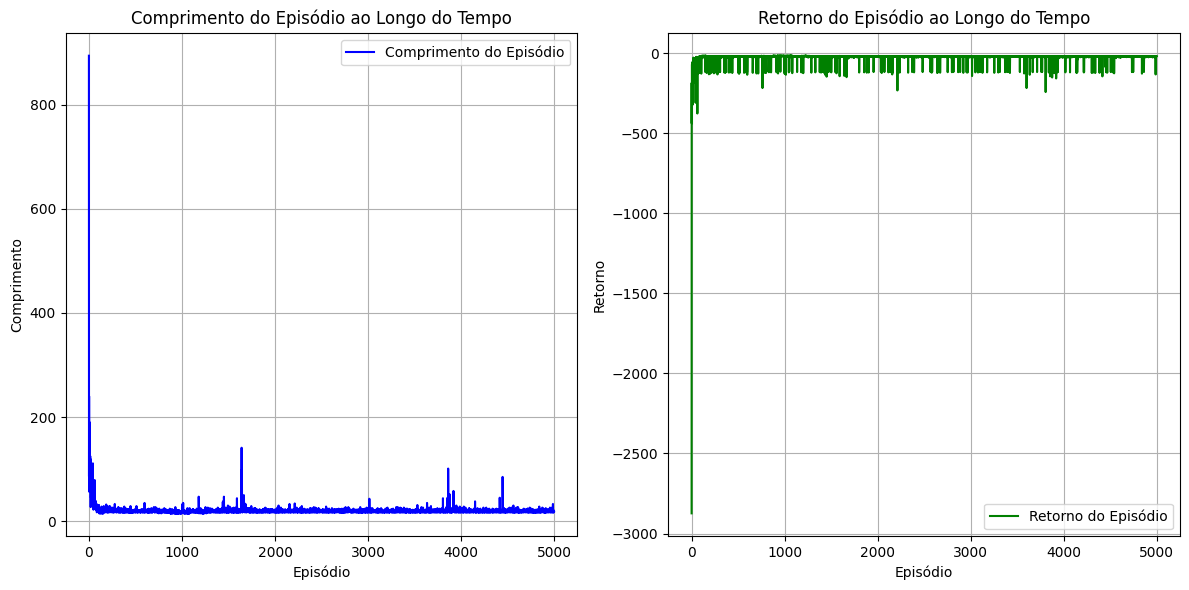

In [24]:
# Plotando o a duração dos episódios por epísodio e a recompensa total por episódio
for ep, resultados in resultados_episodios.items():
    print(f"\nResultados para {ep} episódios:")
    plotar_metricas(resultados['ep_len'], resultados['ep_ret'])

### Impacto do gamma

In [16]:
# Teste variando o gamma (fator de desconto)
gammas_variar = [0.5, 0.8, 0.9, 0.95, 0.99]
resultados_gamma = {}

# Hiperparâmetros fixos
EPISODIOS_FIXO = 1000
ALPHA_FIXO = 0.2
EPSILON_FIXO = 0.1

print("Testando impacto do gamma (fator de desconto)...")
for gamma in gammas_variar:
    print(f"Executando com gamma = {gamma}...")
    env_teste = gym.make("CliffWalking-v0")
    
    q_table, ep_len, ep_ret, politica = sarsa(
        env_teste,
        episodes=EPISODIOS_FIXO,
        alpha=ALPHA_FIXO,
        gamma=gamma,
        epsilon=EPSILON_FIXO
    )
    
    resultados_gamma[gamma] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de gamma concluído!")

Testando impacto do gamma (fator de desconto)...
Executando com gamma = 0.5...
Executando com gamma = 0.8...
Executando com gamma = 0.9...
Executando com gamma = 0.95...
Executando com gamma = 0.99...
Teste de gamma concluído!



Resultados para gamma = 0.5:


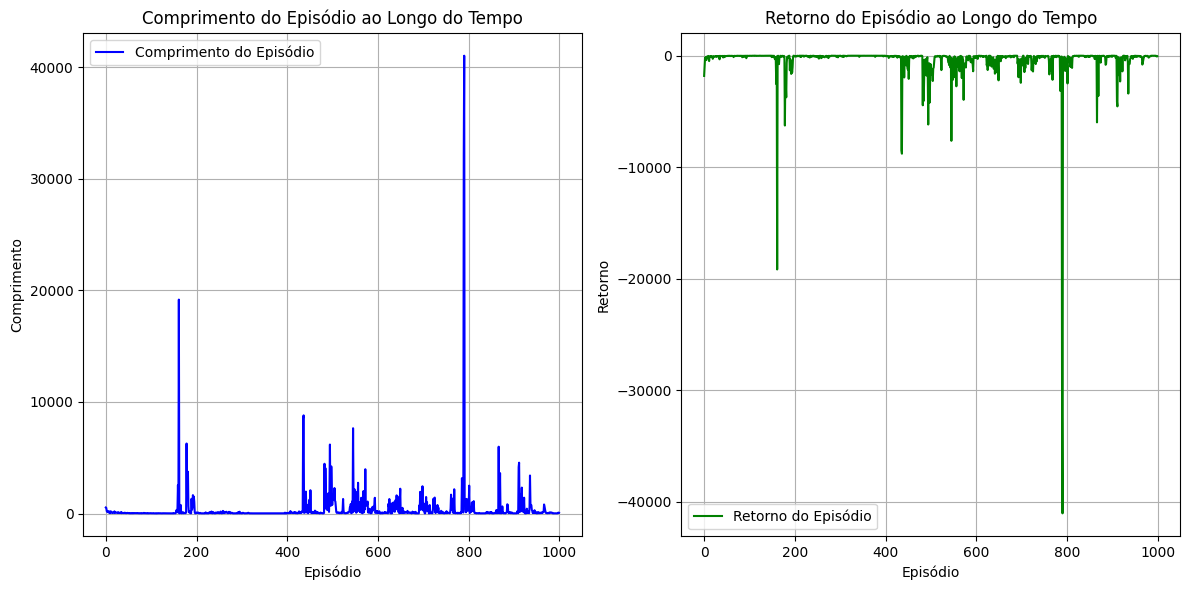


Resultados para gamma = 0.8:


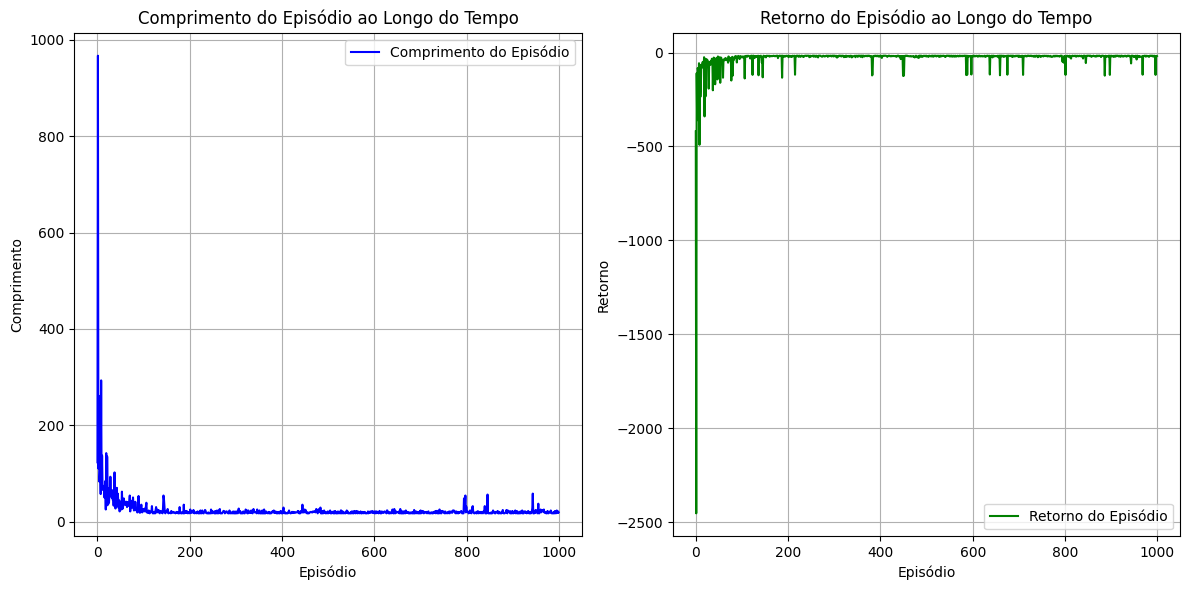


Resultados para gamma = 0.9:


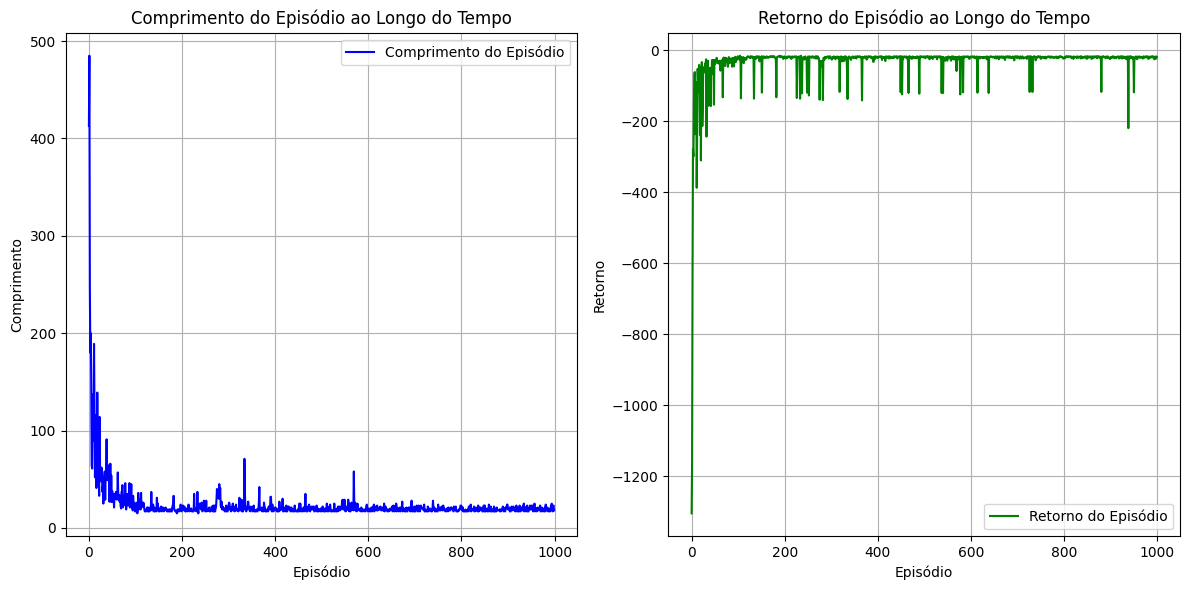


Resultados para gamma = 0.95:


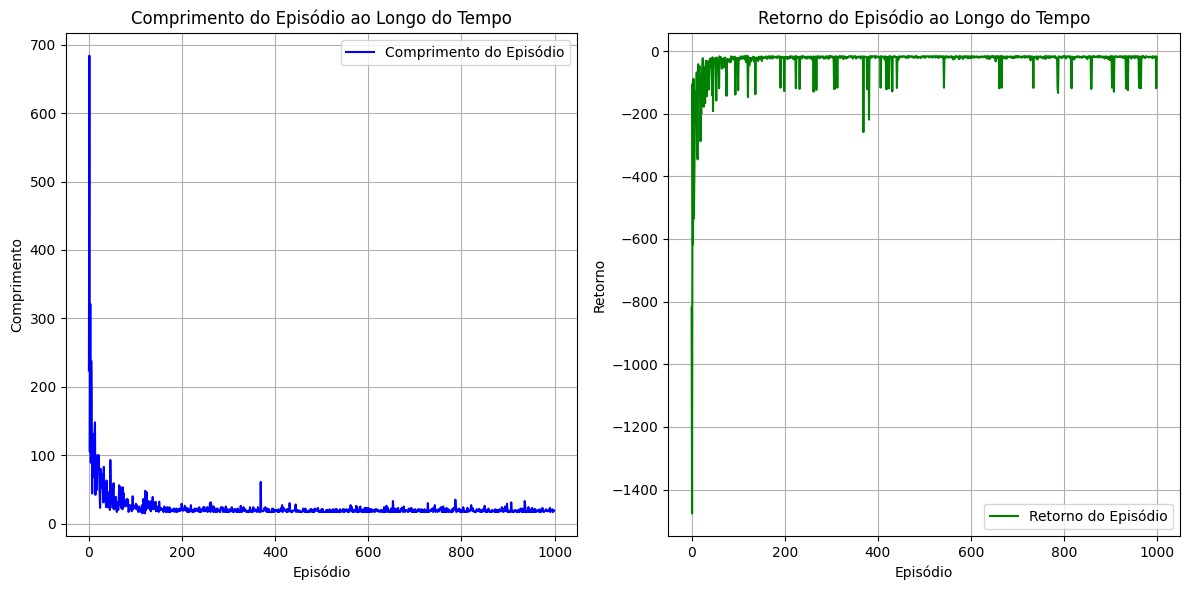


Resultados para gamma = 0.99:


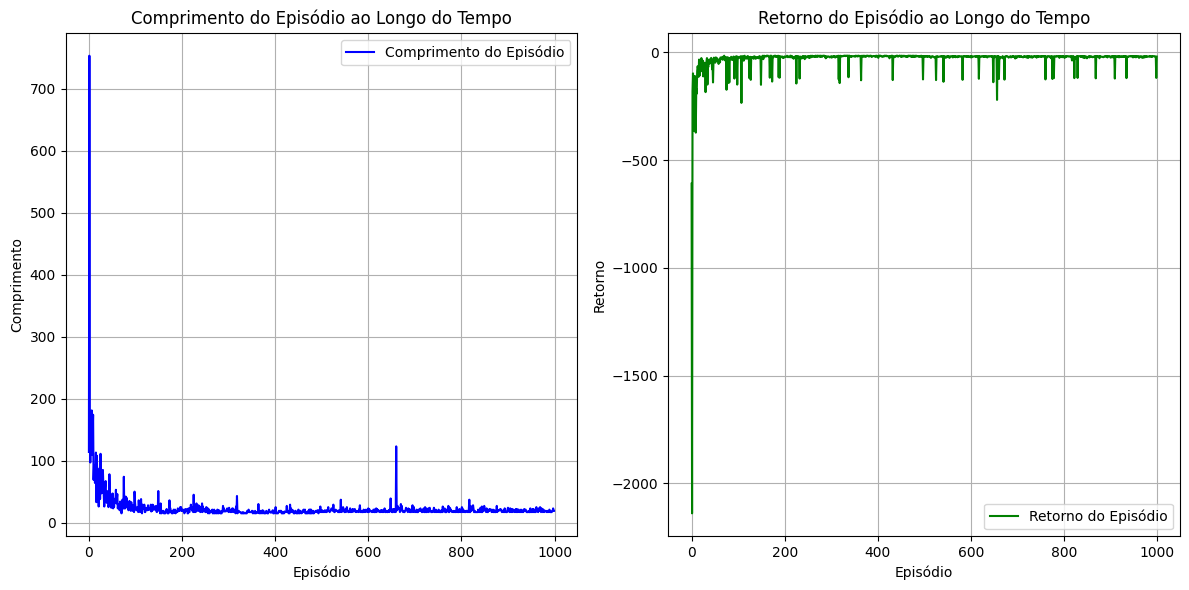

In [25]:
# Plotando o a duração dos episódios por epísodio e a recompensa total por episódio
for gamma, resultados in resultados_gamma.items():
    print(f"\nResultados para gamma = {gamma}:")
    plotar_metricas(resultados['ep_len'], resultados['ep_ret'])

### Impacto do epsilon

In [18]:
# Teste variando o epsilon (taxa de exploração)
epsilons_variar = [0.01, 0.05, 0.1, 0.3, 0.5]
resultados_epsilon = {}

# Hiperparâmetros fixos
EPISODIOS_FIXO = 1000
ALPHA_FIXO = 0.2
GAMMA_FIXO = 0.99

print("Testando impacto do epsilon (taxa de exploração)...")
for epsilon in epsilons_variar:
    print(f"Executando com epsilon = {epsilon}...")
    env_teste = gym.make("CliffWalking-v0")
    
    q_table, ep_len, ep_ret, politica = sarsa(
        env_teste,
        episodes=EPISODIOS_FIXO,
        alpha=ALPHA_FIXO,
        gamma=GAMMA_FIXO,
        epsilon=epsilon
    )
    
    resultados_epsilon[epsilon] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de epsilon concluído!")

Testando impacto do epsilon (taxa de exploração)...
Executando com epsilon = 0.01...
Executando com epsilon = 0.05...
Executando com epsilon = 0.1...
Executando com epsilon = 0.3...
Executando com epsilon = 0.5...
Teste de epsilon concluído!



Resultados para 100 episódios:


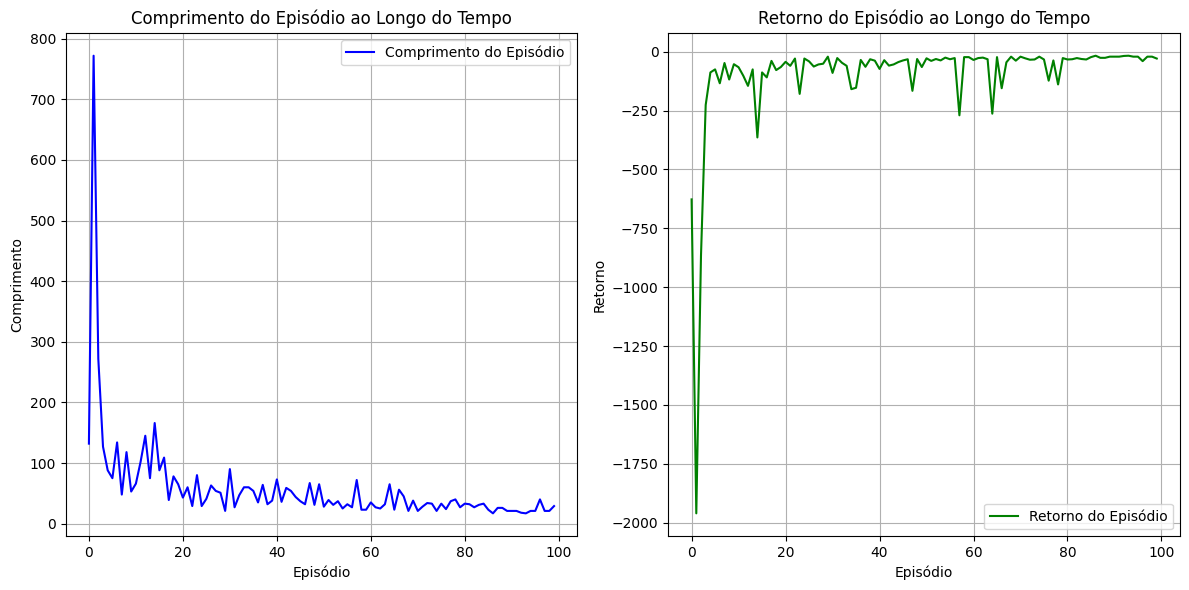


Resultados para 500 episódios:


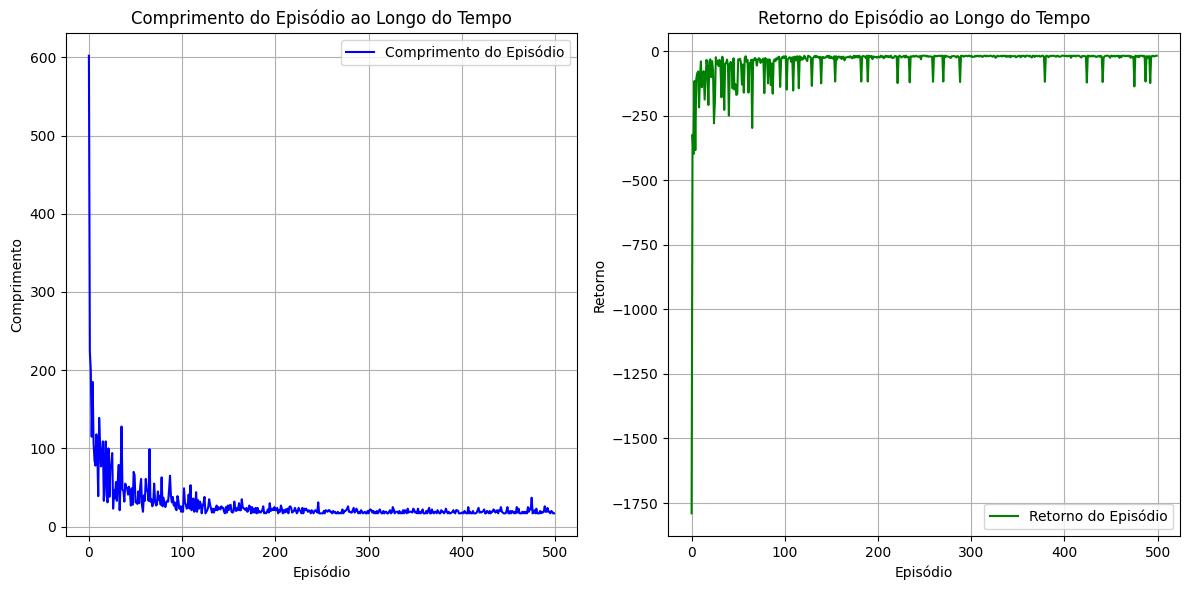


Resultados para 1000 episódios:


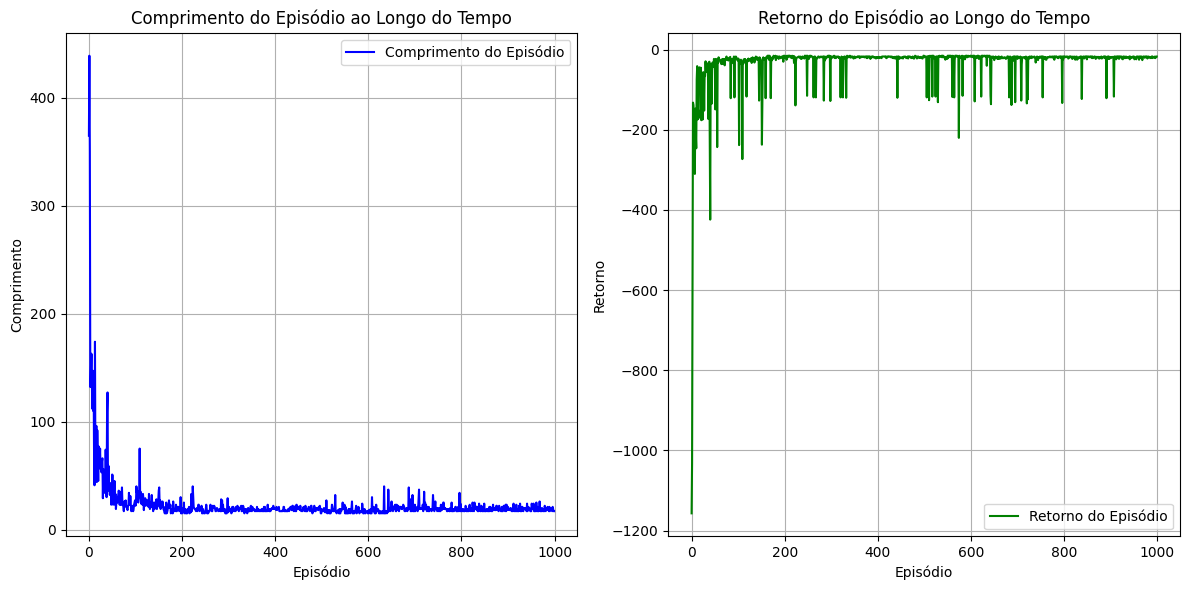


Resultados para 2000 episódios:


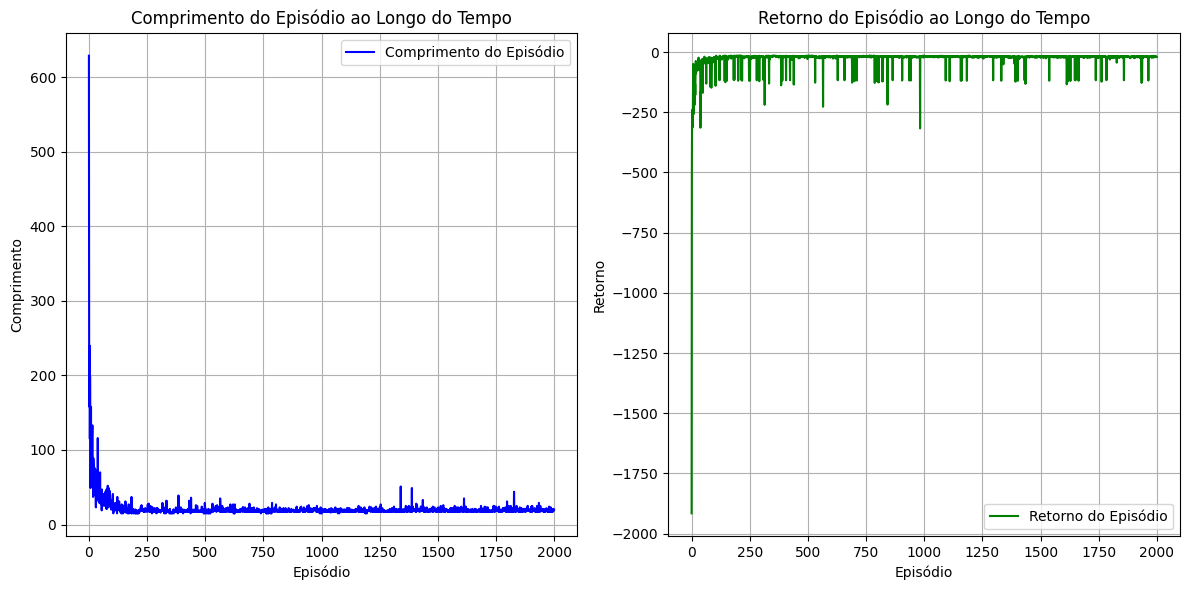


Resultados para 5000 episódios:


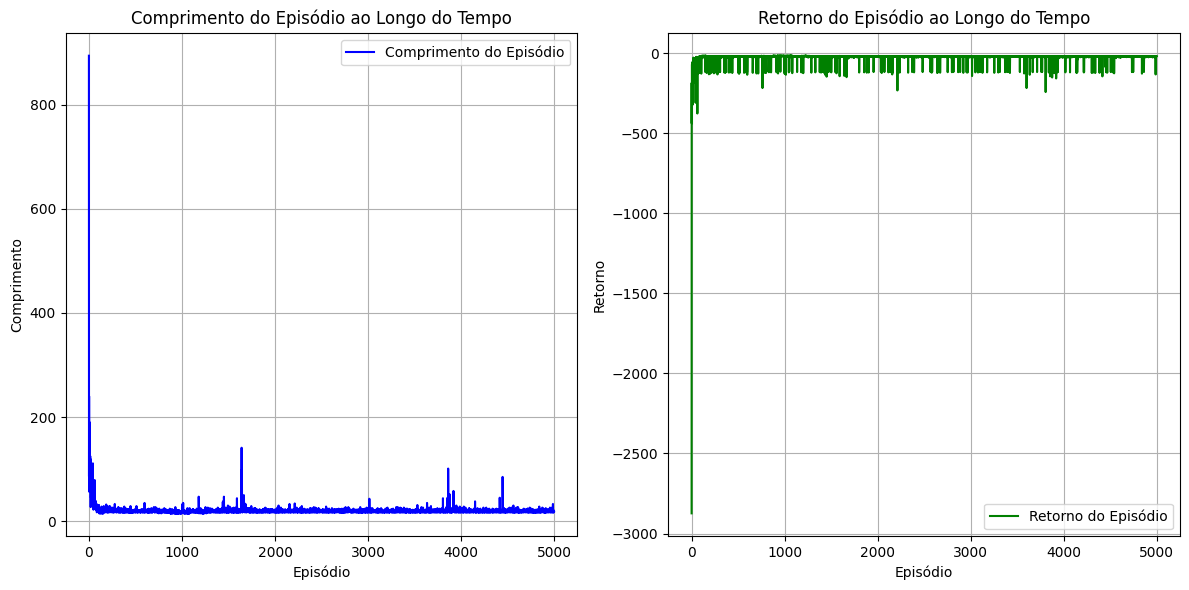

In [26]:
# Plotando o a duração dos episódios por epísodio e a recompensa total por episódio
for ep, resultados in resultados_episodios.items():
    print(f"\nResultados para {ep} episódios:")
    plotar_metricas(resultados['ep_len'], resultados['ep_ret'])